In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

COVID-19 pandemic predictions
----------------------------------------------

This notebook shows daily updated predictions for the COVID-19 pandemic based on a SIR model with a correction for quarantine measures.

Model
---------

This analysis code uses the recent model from https://arxiv.org/abs/2002.07572 (Brockmann, Maier) which has been verified on the course of the COVID-19 epidemic in China.

The daily updated date is taken from the John Hopkins University Center for Systems Science and Engineering https://systems.jhu.edu/research/public-health/ncov/ (https://github.com/CSSEGISandData/COVID-19).

For a basic introduction into SIR models consult:
https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology

Plots
------

The plots show the course of the pandemic in the respective countries. The number of cases is given on a logarithmic scale on the y-axis. The time on the x-axis is given in the number of days since the first confirmed case on the respective country.

The orange crosses show the number of confirmed total cases of infected, cured or deceased individuals. The black line is a model fit on exactly these numbers. The blue line depicts the estimated number of acute infected individuals (including unknown cases) on a current day. 

Each plot also depicts the peak day of the pandamic (purple line) and the number of acute cases on this day (in the text on the x-axis). The number is given in scientific notation: 

    1.2e+03 = 1.2 * 10^3
    


In [2]:
import csv
import codecs
import urllib
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
from SIRX import SIRXConfirmedModel

In [4]:
data = {}
dates = []

data_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
   
datafile = urllib.request.urlopen(data_url)

reader = csv.reader(codecs.iterdecode(datafile, 'utf-8'))

first_row = next(reader)

dates = [ datetime.strptime(d, '%m/%d/%y').date() for d in first_row[4:] ]

for row in reader:
    country = row[1]
        
    if country in data:
        data[country] = [ d + int(e) for d,e in zip(data[country],row[4:]) ]
    else:
        data[country] = [ int(e) for e in row[4:] ]
        
    #print(country)

In [5]:
model = SIRXConfirmedModel()

In [6]:
population = {  
                'Netherlands' : 17180000, 
                'Italy' :       60480000,
                'Germany' :     82790000,
                'Spain' :       46660000,
                'United Kingdom' : 66440000,
                'France' : 66990000,
                'Korea, South' : 51470000,
                'Iran' : 81160000,
                'Portugal' :     10290000,
                'Greece' : 10740000,
                'Norway' : 5368000,
                'Switzerland' : 8570000,
                'Sweden' : 10120000,
                'Austria' : 8822000,
                'Belgium' : 11400000,
                'Poland' : 37980000,
                'US' : 327200000,
                'Denmark' : 5603000,
                'Lebanon' : 6082000
                #'China' : 1386000000
                #'Thailand' : 69040000,
             }

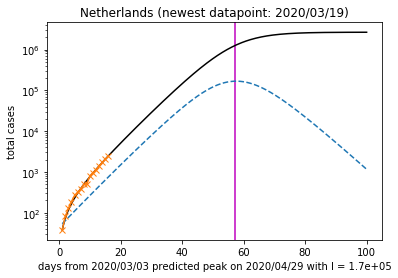

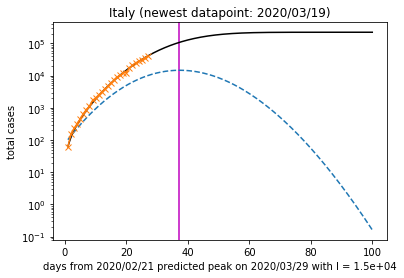

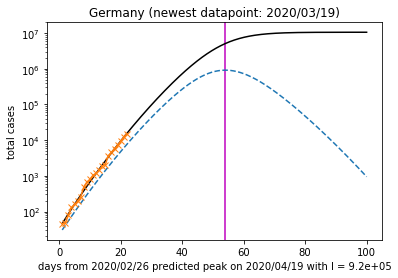

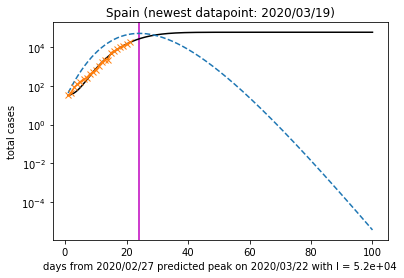

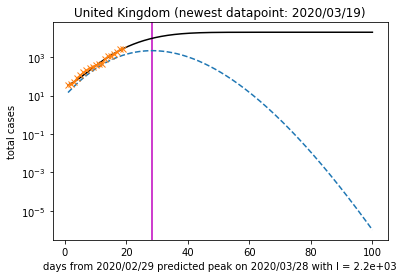

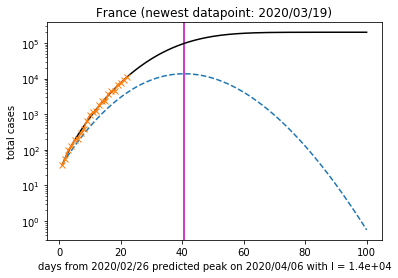

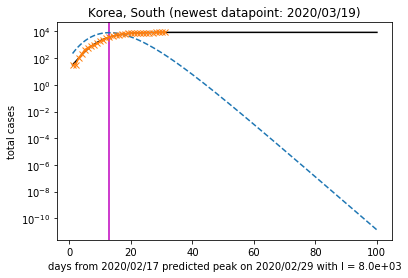

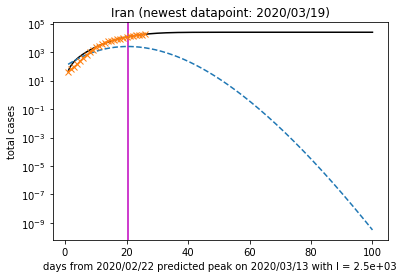

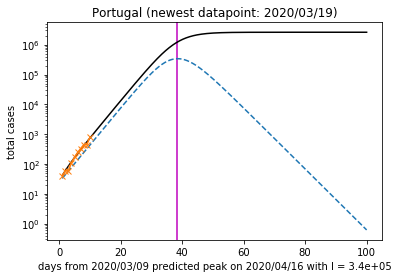

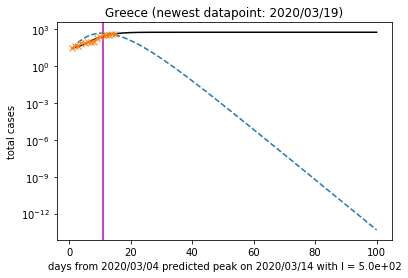

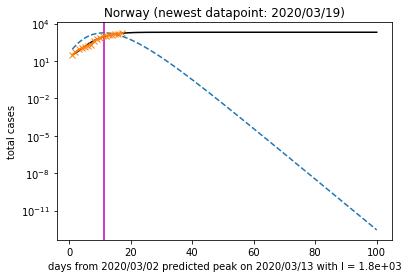

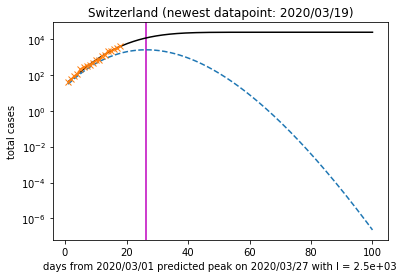

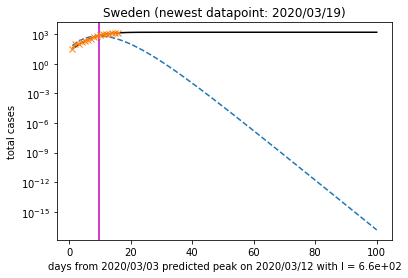

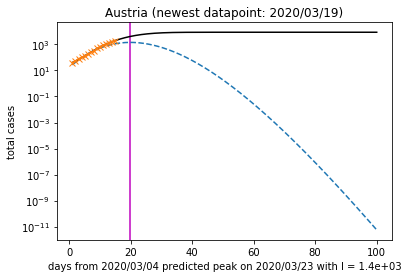

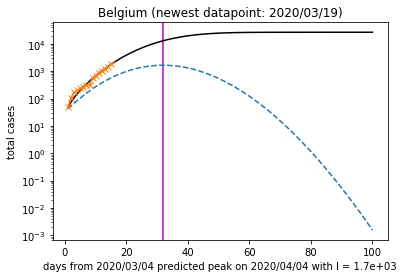

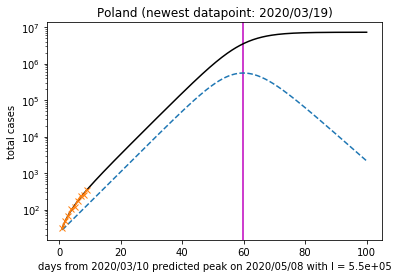

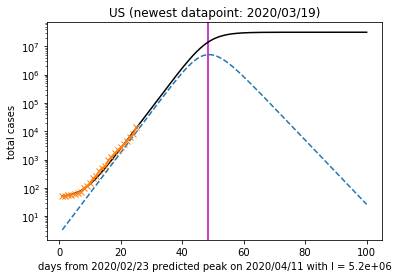

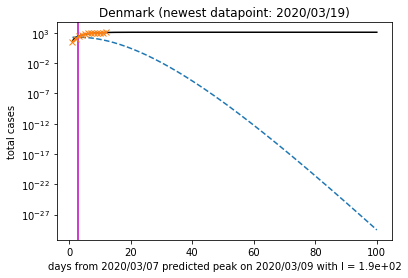

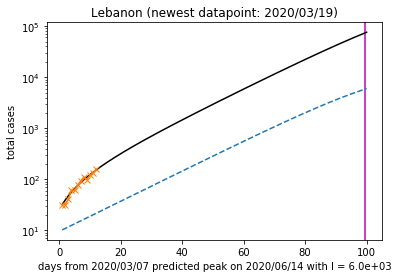

In [7]:
for country, pop in population.items():
    #print(country)
    #print("Population size", pop)

    t0 = next( i for i,d in enumerate( data[country] ) if d > 30 )
    
    
    #if country == 'Netherlands':
    #    t0 += 2
    
    #if country == 'France':
    #    t0 += 10
    #    # atypical start of the pandemic in France
        
    #if country == 'Korea, South':
    #    t0 += 5
    #    # atypical start of the pandemic in South Korea
        
    #if country == 'Sweden':
    #    t0 += 5
    #    # atypical start of the pandemic in Sweden
        
    #if country == 'US':
    #    t0 += 15
    
    
    
    cases = data[country][t0:]
    pop = population[country]
    
        
    #print("start on ", dates[t0])
    t = [ (d - dates[t0-1]).total_seconds() / 24 / 3600 for d in dates[t0:] ]

    out = model.fit(t,cases,maxfev=1000,N=pop)
    params = out.params
    
    #print(params)
    
    #print(cases)
    
    N = params['N']
    tt = np.logspace(np.log(t[0]), np.log(100), 1000,base=np.exp(1))

    result = model.SIRX(tt, cases[0], 
                        params['eta'],
                        params['rho'],
                        params['kappa'],
                        params['kappa0'],
                        N,
                        params['I0_factor'],
                        )
    X = result[2,:]*N
    I = result[1,:]*N
    
    imax = np.where(I == np.amax(I))[0]
    tmax = np.exp(imax/1000*np.log(100))[0]
    max_date = dates[t0-1] + timedelta(days=tmax)
    
    #print(X[-1])
    
    csfont = {}
    
    plt.axes(yscale='log')
    plt.xlabel('days from ' + dates[t0-1].strftime("%Y/%m/%d") \
               + " predicted peak on " \
               + max_date.strftime("%Y/%m/%d") \
               + " with I = %.1e" % float(np.amax(I)),**csfont)
               
    plt.ylabel('total cases',**csfont)
    plt.axvline(x=tmax,c='m')
    
    textstr = '\n'.join((
    r'predicted peak on %s' % (max_date.strftime("%Y/%m/%d"), ),
    r'with I = %.1e' % (float(np.amax(I)), )))
    
    plt.title(country + " (newest datapoint: %s)" % (dates[-1].strftime("%Y/%m/%d")),**csfont)
    
    plt.plot(tt, X,'-',c='k')
    plt.plot(tt, I,'--',lw=1.5)
    plt.plot(t, cases,marker='x')
    
    plt.show()
    
    #print('*'*50)
